Notebook of local validation auc score: 0.810, user based split. Unfortunately, I got this score 12 hours prior to the competition ends and submission is not successful - LB: 0.776. I think there is no problem in this validation scheme here, and found some bugs in my inference pipeline. I will keep trying until I got the same LB score with validation score. Reporting any mistake will be welcomed and thankful since I am new to transformer.

# Acknowledgement
This notebook originated from the sakt kernels. 
- Mostly from https://www.kaggle.com/gilfernandes/riiid-self-attention-transformer - Novel dataset amplification with long content sequence users.
- https://www.kaggle.com/manikanthr5/riiid-sakt-model-training-public - I am new to transformer and learned so much from the discussion in comments section in this kernel. Thanks to the author and other commenters.
- https://www.kaggle.com/m10515009/saint-model-training - I could get success by adopting nn.Transformer instead of my implementation. Validation auc had stucked in 0.770 for 5 days, but this kernel gives me to overcome. All credits to his kernel.

# LSI topic modeling for tag sequence of each question
**Adding tags lsi as another categorical embeddings besides part embeddings.** I haven't tested pure SAINT+, but I am sure lsi tag embeddings definitely would give advantage to the model. The power lsi tags topic has been proven in LGBM gain plots. 
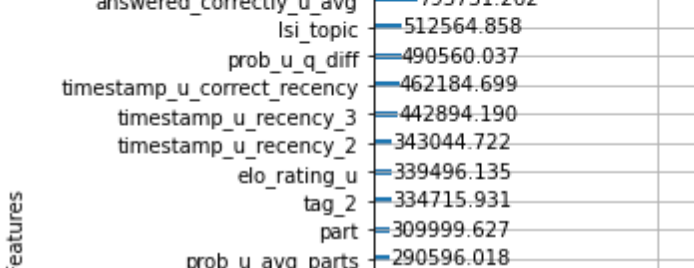
It is explained [here](https://www.kaggle.com/gaozhanfire/riiid-lgbm-val-0-788-offline-and-lsimodel-updated) how to get the lsi topic, but I was using parameter topic=1000, though it did not give 1000 topics but 128 topics. I checked my setting somehow gives better result.

In [ ]:
import gc
import random
import pickle
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import datatable as dt
from transformers import get_linear_schedule_with_warmup

In [ ]:
MAX_SEQ = 100
ACCEPTED_USER_CONTENT_SIZE = 10
EMBED_SIZE = 256
BATCH_SIZE = 256
DROPOUT=0.1
ES_PATIENCE = 5
LR = 1e-3
EPOCHS = 30
WARMUP_PROP = 0.1
SECOND_TRAIN = False
SECOND_TRAIN_EPOCH = 8

SAINT_PICKLE_PATH = "../input/saint-final"
SAINT_MODEL_PATH = "../input/saint-final-2/saintv120.pth"

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load Data

In [ ]:
path = Path('../input')
assert path.exists()

In [ ]:
data_types_dict = {
    'content_type_id': 'bool',
    'timestamp': 'int64',
    'user_id': 'int32', 
    'content_id': 'int16', 
    'task_container_id': 'int32', 
    'answered_correctly': 'int8', 
    'prior_question_elapsed_time': 'float32', 
    'prior_question_had_explanation': 'bool'
}
target = 'answered_correctly'

### Pre-process

In [ ]:
# # train_df = dt.fread(path/'riiid-test-answer-prediction/train.csv', columns=set(data_types_dict.keys())).to_pandas()
# # questions_df = pd.read_pickle(path/'question-features-0102/questions.pickle')[["question_id", "part", "lsi_topic"]]
# # questions_df["lsi_topic"] = questions_df["lsi_topic"].fillna(-1)
# # questions_df["lsi_topic"] = questions_df["lsi_topic"].map(dict(map(lambda x: (x[1],x[0]), enumerate(questions_df["lsi_topic"].fillna(-1).unique()))))
# # questions_df["lsi_topic"] = questions_df["lsi_topic"] + 1
# # train_df = train_df[train_df.content_type_id == False]
# # train_df = pd.merge(train_df, questions_df, left_on = 'content_id', right_on = 'question_id', how = 'left')

# #arrange by timestamp
# # train_df = train_df.sort_values(['user_id','timestamp'], ascending=True).reset_index(drop = True)
# # del train_df['timestamp']
# del train_df['content_type_id']
# # train_df["lag"] = train_df.groupby("user_id")["timestamp"].shift()
# # train_df["lag"] = train_df["timestamp"] - train_df["lag"]
# n_skill = train_df["content_id"].nunique()
# print("number skills", n_skill)
# train_df["prior_question_elapsed_time"].fillna(0, inplace=True)
# # train_df["lag"].fillna(0, inplace=True)
# # train_df["prior_question_elapsed_time"].fillna(0, inplace=True)
# train_df["prior_question_elapsed_time"] = (train_df["prior_question_elapsed_time"] // 100).clip(0,300)
# # train_df["lag"] = (train_df["lag"]//(100*60)).clip(0, 1440)

In [ ]:
# train_df['last_timestamp'] = train_df[['user_id', 'timestamp']].groupby(['user_id'])['timestamp'].shift(1, fill_value=0)
# train_df['last_timestamp'] = train_df[['user_id', 'task_container_id', 'last_timestamp']].groupby(['user_id', 'task_container_id'])['last_timestamp'].transform('first')
# # df['lagtime1'] = df['timestamp'] - df['last_timestamp']

# train_df['last_task_container_size'] = train_df[['user_id', 'task_container_id']].groupby(['user_id', 'task_container_id'])['task_container_id'].transform('size')
# train_df['last_task_container_size'] = train_df[['user_id', 'last_task_container_size']].groupby(['user_id'])['last_task_container_size'].shift(1, fill_value=0)
# train_df['last_task_container_size'] = train_df[['user_id', 'task_container_id', 'last_task_container_size']].groupby(['user_id', 'task_container_id'])['last_task_container_size'].transform('first')

# train_df['lag'] = train_df['timestamp'] - train_df['last_timestamp'] - (train_df['prior_question_elapsed_time'] * train_df['last_task_container_size'])
# train_df["lag"] = (train_df["lag"]//(100*60)).clip(0, 1440)

In [ ]:
# train_df['last_timestamp'] = train_df[['user_id', 'timestamp']].groupby(['user_id'])['timestamp'].shift(1, fill_value=0)
# train_df['last_timestamp'] = train_df[['user_id', 'task_container_id', 'last_timestamp']].groupby(['user_id', 'task_container_id'])['last_timestamp'].transform('first')
# # df['lagtime1'] = df['timestamp'] - df['last_timestamp']

# train_df['last_task_container_size'] = train_df[['user_id', 'task_container_id']].groupby(['user_id', 'task_container_id'])['task_container_id'].transform('size')
# train_df['last_task_container_size'] = train_df[['user_id', 'last_task_container_size']].groupby(['user_id'])['last_task_container_size'].shift(1, fill_value=0)
# train_df['last_task_container_size'] = train_df[['user_id', 'task_container_id', 'last_task_container_size']].groupby(['user_id', 'task_container_id'])['last_task_container_size'].transform('first')

# train_df['lag'] = train_df['timestamp'] - train_df['last_timestamp'] - (train_df['prior_question_elapsed_time'] * train_df['last_task_container_size'])
# train_df["lag"] = (train_df["lag"]//(100*60)).clip(0, 1440)

In [ ]:
# %%time
# group = train_df[['user_id', 'content_id', 'answered_correctly', 'lag', 'prior_question_elapsed_time', 'part', 'lsi_topic']].groupby('user_id').apply(lambda r: (r['content_id'].values, r['answered_correctly'].values, r['lag'].values, r['prior_question_elapsed_time'].values, r['part'].values, r['lsi_topic'].values))

# del train_df
# group.to_pickle("./groupv1.pickle")

In [ ]:
n_skill = 13523
n_part = 7
n_et = 300
n_lt = 1441
n_lsi = 128

In [ ]:
def load_group():
    group = None
    for i in range(10):
        with open(f"{SAINT_PICKLE_PATH}/{i}groupv1.pickle", "rb") as f:
            if group is None:
                group = pickle.load(f)
            else:
                group = pd.concat([group, pickle.load(f)])
        gc.collect()
    gc.collect()
    return group
group = load_group()

### Data Loaders

In [ ]:
class SAINTDataset(Dataset):
    def __init__(self, group, n_skill, n_et, n_lt, n_pt=7, max_seq=100):
        super(SAINTDataset, self).__init__()
        self.samples, self.n_skill, self.max_seq = {}, n_skill, max_seq
        self.n_et, self.n_lt, self.n_pt = n_et, n_lt, n_pt
        
        self.user_ids = []
        for i, user_id in enumerate(group.index):
            if(i % 10000 == 0):
                print(f'Processed {i} users')
            content_id, answered_correctly, lag, elapsed_time, part, lsi_topic = group[user_id]
            if len(content_id) >= ACCEPTED_USER_CONTENT_SIZE:
                if len(content_id) > self.max_seq:
                    total_questions = len(content_id)
                    last_pos = total_questions // self.max_seq
                    for seq in range(last_pos):
                        index = f"{user_id}_{seq}"
                        self.user_ids.append(index)
                        start = seq * self.max_seq
                        end = (seq + 1) * self.max_seq
                        self.samples[index] = (content_id[start:end], answered_correctly[start:end], lag[start:end], elapsed_time[start:end], part[start:end], lsi_topic[start:end])
                    if len(content_id[end:]) >= ACCEPTED_USER_CONTENT_SIZE:
                        index = f"{user_id}_{last_pos + 1}"
                        self.user_ids.append(index)
                        self.samples[index] = (content_id[end:], answered_correctly[end:], lag[end:], elapsed_time[end:], part[end:], lsi_topic[end:])
                else:
                    index = f'{user_id}'
                    self.user_ids.append(index)
                    self.samples[index] = (content_id, answered_correctly, lag, elapsed_time, part, lsi_topic)
                
                
    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        content_id, answered_correctly, lag, elapsed_time, part, lsi_topic = self.samples[user_id]
        seq_len = len(content_id)
        
        content_id_seq = np.zeros(self.max_seq, dtype=int)
        answered_correctly_seq = np.zeros(self.max_seq, dtype=int)
        c_seq = np.zeros(self.max_seq, dtype=int)
        lag_seq = np.zeros(self.max_seq, dtype=int)
        elapsed_time_seq = np.zeros(self.max_seq, dtype=int)
        part_seq = np.zeros(self.max_seq, dtype=int)
        lsi_topic_seq = np.zeros(self.max_seq, dtype=int)
        if seq_len >= self.max_seq:
            content_id_seq[:] = content_id[-self.max_seq:]
            answered_correctly_seq[:] = answered_correctly[-self.max_seq:]
            c_seq[1:] = answered_correctly[-self.max_seq:-1] + 1
            lag_seq[1:] = lag[-self.max_seq:-1] + 1
            elapsed_time_seq[1:] =  elapsed_time[-self.max_seq:-1] + 1
            part_seq[:] = part[-self.max_seq:]
            lsi_topic_seq[:] = lsi_topic[-self.max_seq:]
        else:
            content_id_seq[-seq_len:] = content_id
            answered_correctly_seq[-seq_len:] = answered_correctly
            c_seq[-seq_len+1:] = answered_correctly[:-1] + 1
            lag_seq[-seq_len+1:] = lag[:-1] + 1
            elapsed_time_seq[-seq_len+1:] = elapsed_time[:-1] + 1
            part_seq[-seq_len:] = part
            lsi_topic_seq[-seq_len:] = lsi_topic
            
        target_id = content_id_seq
        label = answered_correctly_seq
        
        x = content_id_seq.copy()
        pt_x = part_seq.copy()
        lsi_x = lsi_topic_seq.copy()
        c = c_seq.copy()
        et = elapsed_time_seq.copy()
        lt = lag_seq.copy()
        return x, target_id, label, pt_x, lsi_x, c, et, lt

In [ ]:
TEST_SIZE = 0.1
train, val = train_test_split(group, test_size = TEST_SIZE)

In [ ]:
train_dataset = SAINTDataset(train, n_skill, n_et=n_et, n_lt=n_lt, max_seq=MAX_SEQ)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
del train

In [ ]:
val_dataset = SAINTDataset(val, n_skill, n_et=n_et, n_lt=n_lt, max_seq=MAX_SEQ)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
del val

In [ ]:
sample_batch = next(iter(train_dataloader))
sample_batch[0].shape, sample_batch[1].shape, sample_batch[2].shape, sample_batch[3].shape, sample_batch[4].shape, sample_batch[5].shape

### Define model

In [ ]:
class FFN(nn.Module):
    def __init__(self, state_size = 200, forward_expansion = 1, bn_size=MAX_SEQ - 1):
        super(FFN, self).__init__()
        self.state_size = state_size
        
        self.lr1 = nn.Linear(state_size, forward_expansion * state_size)
        self.relu = nn.ReLU()
        self.lr2 = nn.Linear(forward_expansion * state_size, state_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.lr1(x))
        x = self.lr2(x)
        return self.dropout(x)

FFN()

In [ ]:
def future_mask(seq_length):
    future_mask = np.triu(np.ones((seq_length, seq_length)), k=1).astype('bool')
    return torch.from_numpy(future_mask)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_skill, n_pt=7, n_lsi=n_lsi, max_seq=100, embed_dim=128, dropout = DROPOUT, forward_expansion = 1, num_layers=1, heads = 8):
        super(Encoder, self).__init__()
        self.n_skill, self.embed_dim = n_skill, embed_dim
        self.embedding = nn.Embedding(n_skill + 1, embed_dim)
        self.pos_embedding = nn.Embedding(max_seq, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.n_pt = n_pt
        self.pt_embedding = nn.Embedding(n_pt + 1, embed_dim)
        self.n_lsi = n_lsi
        self.lsi_embedding = nn.Embedding(n_lsi + 1, embed_dim)
        self.layer_normal = nn.LayerNorm(embed_dim) 
        
    def forward(self, x, question_ids, pt_x, lsi_x):
        device = x.device
        x = self.embedding(x)
        pt_x = self.pt_embedding(pt_x)
        lsi_x = self.lsi_embedding(lsi_x)
        pos_id = torch.arange(x.size(1)).unsqueeze(0).to(device)
        pos_x = self.pos_embedding(pos_id)
        x = self.dropout(self.layer_normal(x + pos_x + pt_x + lsi_x))
        return x

    
class Decoder(nn.Module):
    def __init__(self, n_et=n_et, n_lt=n_lt, max_seq=100, embed_dim=128, dropout = DROPOUT, forward_expansion = 1, num_layers=1, heads = 8):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.pos_embedding = nn.Embedding(max_seq, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        self.n_response = 2
        self.n_et = n_et
        self.n_lt = n_lt
        self.response_embedding = nn.Embedding(self.n_response + 2, embed_dim)
        self.et_embedding = nn.Embedding(self.n_et + 2, embed_dim)
        self.lt_embedding = nn.Embedding(self.n_lt + 2, embed_dim)
        self.layer_normal = nn.LayerNorm(embed_dim) 
        
    def forward(self, c, et, lt):
        device = c.device
        c = self.response_embedding(c)
        pos_id = torch.arange(c.size(1)).unsqueeze(0).to(device)
        pos_x = self.pos_embedding(pos_id)
        et = self.et_embedding(et)
        lt = self.lt_embedding(lt)
        x = self.dropout(self.layer_normal(c + pos_x + et + lt))
        return x
    
class SAINTModel(nn.Module):
    def __init__(self, n_skill, n_pt=7, n_lsi=n_lsi, n_et=n_et, n_lt=n_lt, max_seq=100, embed_dim=128, dropout = DROPOUT, forward_expansion = 1, enc_layers=3, dec_layers=3, heads = 8):
        super(SAINTModel, self).__init__()
        self.encoder = Encoder(n_skill, n_pt, n_lsi, max_seq, embed_dim, dropout, forward_expansion, num_layers=enc_layers)
        self.decoder = Decoder(n_et, n_lt, max_seq, embed_dim, dropout, forward_expansion, num_layers=dec_layers)
        self.transformer = torch.nn.Transformer(embed_dim, heads, enc_layers, dec_layers, embed_dim*forward_expansion, dropout)
        
        self.ffn = FFN(embed_dim, forward_expansion = forward_expansion)
        self.pred = nn.Linear(embed_dim, 1)
        self.layer_normal = nn.LayerNorm(embed_dim) 
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, question_ids, pt_x, lsi_x, c, et, lt):
        ex = self.encoder(x, question_ids, pt_x, lsi_x)
        dx = self.decoder(c, et, lt)
        
        ex = ex.permute(1, 0, 2)
        dx = dx.permute(1, 0, 2)
        
        device = ex.device
        mask = future_mask(ex.size(0)).to(device)
        att_output = self.transformer(ex, dx, src_mask=mask, tgt_mask=mask)
        att_output = self.layer_normal(att_output)
        att_output = att_output.permute(1, 0, 2) # att_output: [s_len, bs, embed] => [bs, s_len, embed]

        x = self.ffn(att_output)
        x = self.dropout(self.layer_normal(x + att_output))
        x = self.pred(x)
        
        return x.squeeze(-1)

In [ ]:
# Main changes are possibility of forward expansion and stacking of encoding layers
def create_model():
    return SAINTModel(n_skill, n_pt=7, n_lsi=n_lsi, n_et=n_et, n_lt=n_lt, max_seq=MAX_SEQ, embed_dim=EMBED_SIZE, forward_expansion=1, enc_layers=2, dec_layers=2, heads=8, dropout=0.1)
model = create_model()
# model

In [ ]:
def load_from_item(item, debug=False):
    if debug:
        x = item[0]
        target_id = item[1]
        label = item[2]
        pt_x = item[3]
        lsi_x = item[4]
        c = item[5]
        et = item[6]
        lt = item[7]
        target_mask = (target_id != 0)
    else:
        x = item[0].to(device).long()
        target_id = item[1].to(device).long()
        label = item[2].to(device).float()
        pt_x = item[3].to(device).long()
        lsi_x = item[4].to(device).long()
        c = item[5].to(device).long()
        et = item[6].to(device).long()
        lt = item[7].to(device).long()
        target_mask = (target_id != 0)
    
    return x, target_id, label, pt_x, lsi_x, c, et, lt, target_mask

In [ ]:
x, target_id, label, pt_x, lsi_x, c, et, lt, target_mask = load_from_item(sample_batch, debug=True)
model(x, target_id, pt_x, lsi_x, c, et, lt)[0]

### Training

In [ ]:
def update_stats(tbar, train_loss, loss, output, label, num_corrects, num_total, labels, outs):
    train_loss.append(loss.item())
    pred = (torch.sigmoid(output) >= 0.5).long()
    num_corrects += (pred == label).sum().item()
    num_total += len(label)
    labels.extend(label.view(-1).data.cpu().numpy())
    outs.extend(output.view(-1).data.cpu().numpy())
    tbar.set_description('loss - {:.4f}'.format(loss))
    return num_corrects, num_total

def train_epoch(model, dataloader, optim, criterion, scheduler, device="cpu"):
    model.train()
    
    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []
    
    tbar = tqdm(dataloader)
    for item in tbar:
        x, target_id, label, pt_x, lsi_x, c, et, lt, target_mask = load_from_item(item)
        
        optim.zero_grad()
        output = model(x, target_id, pt_x, lsi_x, c, et, lt)
        
        output = torch.masked_select(output, target_mask)
        label = torch.masked_select(label, target_mask)
        
        loss = criterion(output, label)
        loss.backward()
        optim.step()
        scheduler.step()
        
        tbar.set_description('loss - {:.4f}'.format(loss))

def val_epoch(model, val_iterator, criterion, device="cpu"):
    model.eval()

    train_loss = []
    num_corrects = 0
    num_total = 0
    labels = []
    outs = []

    tbar = tqdm(val_iterator)
    for item in tbar:
        x, target_id, label, pt_x, lsi_x,  c, et, lt, target_mask = load_from_item(item)

        with torch.no_grad():
            output = model(x, target_id, pt_x, lsi_x, c, et, lt)
        
        output = torch.masked_select(output, target_mask)
        label = torch.masked_select(label, target_mask)

        loss = criterion(output, label)
        
        num_corrects, num_total = update_stats(tbar, train_loss, loss, output, label, num_corrects, num_total, labels, outs)

    acc = num_corrects / num_total
    auc = roc_auc_score(labels, outs)
    loss = np.average(train_loss)

    return loss, acc, auc


In [ ]:
def do_train(second_train=False):
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
    criterion = nn.BCEWithLogitsLoss()
    # scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
    #                                                 steps_per_epoch=len(train_dataloader), epochs=EPOCHS)

    num_warmup_steps = int(WARMUP_PROP * EPOCHS * len(train_dataloader))
    num_training_steps = int(EPOCHS * len(train_dataloader))
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )

    model.to(device)
    criterion.to(device)
    best_loss = 100
    for epoch in range(EPOCHS):
        train_epoch(model, train_dataloader, optimizer, criterion, scheduler, device)
        val_loss, val_acc, val_auc = val_epoch(model, val_dataloader, criterion, device)
        print("epoch - {} val_loss - {:.5f} acc - {:.5f} auc - {:.5f}".format(epoch + 1, val_loss, val_acc, val_auc))
        if best_loss > val_loss:
            print(f'Best model with val auc: {val_auc}')
            best_loss = val_loss
            torch.save(model.state_dict(), f'../working/saintv1{epoch}.pth')

In [ ]:
do_train(second_train=SECOND_TRAIN)